# This notebook is to systemically evaluate network subselection and its effect on embedding and ML to predict impact/non-impact genes

In [4]:
import sys
sys.path.append("../..")
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import os
import seaborn as sns
import networkx as nx
from src.eda.subset_network import *
from src.eda.eda_functions import *
from src.eda.process_phenotype import *
from src.embedding.network_embedding import network_embedding
import umap
import time
from sklearn.model_selection import train_test_split
from harness.test_harness_class import TestHarness
from harness.utils.parsing_results import *
from harness.th_model_instances.hamed_models.random_forest_classification import random_forest_classification
from harness.th_model_instances.hamed_models.rocklin_models import logistic_classifier
from harness.th_model_instances.perovskite_models.xgboost import gradient_boosted_tree
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
from sys import platform 
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'

In [38]:
start = time.time()
tom_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/Kapoor_TOM.csv', index_col = 0)
end = time.time()
print(f'time delta: {end-start} seconds')

time delta: 373.67288160324097 seconds


## Subset network method 1: choose the nodes from a non-DE module (e.g. 0, 1, 2, 3 or others) and top n DE from module 4

In [94]:
start = time.time()
for gene_num in [75,100]:
    for weight in [0.015, 0.02]:
        module0_n_4_df = get_subnetwork1(0, gene_num, weight, tom_df, output_dir = r'C:\Users\bbche\Documents\GitRepos\assist\data\module0_n_4')
end = time.time()
print(f'time delta: {end-start} seconds')

Number of edges: 73272
Figure num_genes=75,min_weight=0.015 has been saved.
Number of edges: 51662
Figure num_genes=75,min_weight=0.02 has been saved.
Number of edges: 94166
Figure num_genes=100,min_weight=0.015 has been saved.
Number of edges: 66820
Figure num_genes=100,min_weight=0.02 has been saved.
time delta: 64.7409451007843 seconds


In [70]:
start = time.time()
for gene_num in [125, 150]:
    for weight in [0.01, 0.015]:
        module1_n_4_df = get_subnetwork1(1, gene_num, weight, tom_df, output_dir = r'C:\Users\bbche\Documents\GitRepos\assist\data\module1_n_4')
end = time.time()
print(f'time delta: {end-start} seconds')

Number of edges: 82325
Figure num_genes=125,min_weight=0.01 has been saved.
Number of edges: 46303
Figure num_genes=125,min_weight=0.015 has been saved.
Number of edges: 98740
Figure num_genes=150,min_weight=0.01 has been saved.
Number of edges: 54897
Figure num_genes=150,min_weight=0.015 has been saved.
time delta: 101.95783853530884 seconds


In [71]:
start = time.time()
for gene_num in [125, 150]:
    for weight in [0.01, 0.015]:
        module2_n_4_df = get_subnetwork1(2, gene_num, weight, tom_df, output_dir = r'C:\Users\bbche\Documents\GitRepos\assist\data\module2_n_4')
end = time.time()
print(f'time delta: {end-start} seconds')

Number of edges: 57056
Figure num_genes=125,min_weight=0.01 has been saved.
Number of edges: 29758
Figure num_genes=125,min_weight=0.015 has been saved.
Number of edges: 74113
Figure num_genes=150,min_weight=0.01 has been saved.
Number of edges: 39244
Figure num_genes=150,min_weight=0.015 has been saved.
time delta: 89.0810194015503 seconds


In [60]:
start = time.time()
for gene_num in [125, 150]:
    for weight in [0.02, 0.025]:
        module3_n_4_df = get_subnetwork1(3, gene_num, weight, tom_df, output_dir = r'C:\Users\bbche\Documents\GitRepos\assist\data\module3_n_4')
end = time.time()
print(f'time delta: {end-start} seconds')

Number of edges: 76334
Figure num_genes=125,min_weight=0.02 has been saved.
Number of edges: 60395
Figure num_genes=125,min_weight=0.025 has been saved.
Number of edges: 89152
Figure num_genes=150,min_weight=0.02 has been saved.
Number of edges: 70175
Figure num_genes=150,min_weight=0.025 has been saved.
time delta: 75.8434157371521 seconds


## Subset network method 2: choose the nodes from module 4 (DE module) and by changing the gene_num and min_weight, the nodes from module 4 could pull nodes from other modules if the weights are large enough

In [95]:
start = time.time()
for gene_num in [200,250]:
    for weight in [0.008,0.01]:
        module4_df = get_subnetwork2(gene_num, weight, tom_df, output_dir = r'C:\Users\bbche\Documents\GitRepos\assist\data\module_4')
end = time.time()
print(f'time delta: {end-start} seconds')

Number of edges: 64975
Figure num_genes=200,min_weight=0.008 has been saved.
Number of edges: 50196
Figure num_genes=200,min_weight=0.01 has been saved.
Number of edges: 82208
Figure num_genes=250,min_weight=0.008 has been saved.
Number of edges: 63583
Figure num_genes=250,min_weight=0.01 has been saved.
time delta: 93.00227165222168 seconds


# Run embedding on "pre-selected" parameters to subselect the network based on the histograms and # of edges obtained

In [75]:
G0_n_4, module0_n_4_df = get_subnetwork1(0, 100, 0.015, plot_hist = False)
G1_n_4, module1_n_4_df = get_subnetwork1(1, 125, 0.01, plot_hist = False)
G2_n_4, module2_n_4_df = get_subnetwork1(2, 150, 0.01, plot_hist = False)
G3_n_4, module3_n_4_df = get_subnetwork1(3, 150, 0.02, plot_hist = False)
G4, module4_df = get_subnetwork2(250, 0.008, plot_hist = False)

Number of edges: 94166
Number of edges: 82325
Number of edges: 74113
Number of edges: 89152
Number of edges: 82208


In [76]:
subnetwork_names = ['m0_4_100_0.015','m1_4_125_0.01','m2_4_150_0.01','m3_4_150_0.02','m4_250_0.008']
for i, G in enumerate([G0_n_4,G1_n_4, G2_n_4, G3_n_4, G4]):
    emb_df = network_embedding(G, 16, 100, 10, 'C:/Users/bbche/Documents/GitRepos/assist/data/embedding_Dec17', subnetwork_names[i]) # use the network with 5k edges as a test (less computationally intensive)

Computing transition probabilities:   0%|      | 1/7510 [00:00<22:59,  5.44it/s]

embedding data saved


Computing transition probabilities:   0%|              | 0/5973 [00:00<?, ?it/s]

embedding data saved


Computing transition probabilities:   0%|      | 1/4333 [00:00<11:13,  6.43it/s]

embedding data saved


Computing transition probabilities:   0%|              | 0/3908 [00:00<?, ?it/s]

embedding data saved


Generating walks (CPU: 1): 100%|██████████████| 100/100 [09:49<00:00,  5.90s/it]


embedding data saved


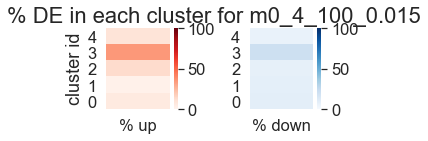

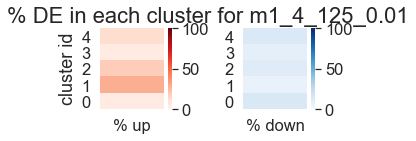

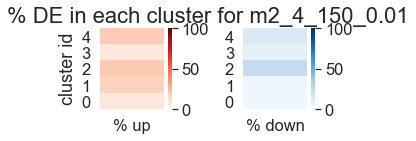

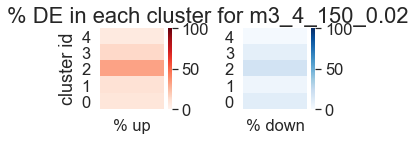

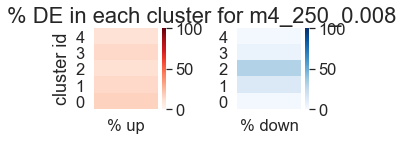

In [78]:
file_path = 'C:/Users/bbche/Documents/GitRepos/assist/data/embedding_Dec17/'
emb_list = []
kmeans_list = []
i = 0
for file in os.listdir(file_path):
    emb = pd.read_csv(file_path + file, index_col = 0)
    emb_list.append(emb)
    kmeans_list.append(run_kmeans(emb, 5))
    cluster_DE_perc(kmeans_list[i], 'kmean_label', subnetwork_names[i])
    i += 1

In [79]:
def process_emb_for_ML(embedding_df):
    embedding_labeled_df = pd.merge(embedding_df, deseq, left_index = True, right_on = 'id')
    embedding_labeled_df['impact'] = 1
    embedding_labeled_df.loc[embedding_labeled_df['log2FoldChange'].between(-0.1, 0.1), 'impact'] = 0
    return embedding_labeled_df

In [80]:
processed_emb_dfs = list(map(process_emb_for_ML, emb_list))

In [81]:
def run_ml(embedding_data, output_dir, description,
           feature_cols_to_use, models_to_test, repeat=6, feature_cols_to_normalize=None,
           sparse_cols_to_use=None, pred_col='impact'):
    th_path = output_dir
    th = TestHarness(output_location = th_path)
    num_sample = embedding_data['impact'].value_counts().min()
    for i in range(repeat):
        emb_subset = embedding_data.groupby('impact').sample(num_sample).reset_index() # subset to have equal samples in the two classes
        train_df, test_df = train_test_split(emb_subset, test_size = 0.2)
        normalize = False
        if feature_cols_to_normalize:
            normalize = True

        for model in models_to_test:
            th.run_custom(function_that_returns_TH_model = model,
                          dict_of_function_parameters={}, training_data = train_df,
                          testing_data = test_df, description = description,
                          target_cols=pred_col, feature_cols_to_use = feature_cols_to_use,
                          index_cols = ['index_col'], normalize = normalize,
                          feature_cols_to_normalize = feature_cols_to_normalize, feature_extraction = False,
                          sparse_cols_to_use=sparse_cols_to_use, predict_untested_data=False)

In [82]:
def plot_ML_results(th_path, description_list, output_dir = None):
    model_dict = {'random_forest_classification': 'Random Forest',
                  'gradient_boosted_tree': 'Gradient Boosted Tree',
                  'logistic_classifier': 'Logistic Regression'}
    sns.set(rc={'figure.figsize': (6, 4)}, font_scale=1.5)
    sns.set_style("white")
    for description in description_list:
        leaderboard_df = query_leaderboard(query={'Description':description},
                               th_output_location=th_path, loo=False, classification=True)
        leaderboard_df['Model Name'] = leaderboard_df['Model Name'].map(model_dict)
        leaderboard_df['Accuracy'] = 100*leaderboard_df['Accuracy']
        agg_acc = leaderboard_df.groupby('Model Name')['Accuracy'].mean()
        print('best accuracy', round(agg_acc.max()))
        ax = sns.boxplot(x = 'Model Name', y = 'Accuracy', data = leaderboard_df)
        ax.set(ylim = (0,100))
        plt.title(description)
        plt.xlabel('')
        plt.axhline(50, color = 'r')
        plt.xticks(rotation = 45, ha = 'right')
        plt.show()
        plt.close()

In [83]:
th_path = 'F:/data/emb_ML_Dec17'
feature_cols = processed_emb_dfs[0].columns[:64].tolist()
for i, emb_df in enumerate(processed_emb_dfs):
    emb_df['index_col'] = range(len(emb_df))
    run_ml(emb_df, output_dir=th_path, description=subnetwork_names[i],feature_cols_to_use=feature_cols, 
           models_to_test = [logistic_classifier, random_forest_classification, gradient_boosted_tree], 
           feature_cols_to_normalize=feature_cols, sparse_cols_to_use=None)


----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 14:35:14
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.01 seconds


C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Testing time was: 0.01 seconds
Run finished at 14:35:14. Total run time = 0.11 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:35:14
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.99 seconds
Testing time was: 0.14 seconds
Run finished at 14:35:16. Total run time = 1.36 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:35:16
Normalizing training and testing splits...
Starting Classification training...
Training time was: 4.93 seconds
Testing time was: 0.01 seconds
Run finished at 14:35:21. Total run 

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Testing time was: 0.01 seconds
Run finished at 14:35:21. Total run time = 0.15 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:35:21
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.96 seconds
Testing time was: 0.18 seconds
Run finished at 14:35:23. Total run time = 1.34 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:35:23
Normalizing training and testing splits...
Starting Classification training...
Training time was: 5.49 seconds
Testing time was: 0.02 seconds
Run finished at 14:35:28. Total run 

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:35:29. Total run time = 0.24 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:35:29
Normalizing training and testing splits...
Starting Classification training...
Training time was: 1.13 seconds
Testing time was: 0.12 seconds
Run finished at 14:35:30. Total run time = 1.33 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:35:30
Normalizing training and testing splits...
Starting Classification training...
Training time was: 4.74 seconds
Testing time was: 0.01 seconds
Run finished at 14:35:35. Total run time = 4.84 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Training time was: 0.01 seconds
Testing time was: 0.02 seconds
Run finished at 14:35:35. Total run time = 0.13 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:35:36
Normalizing training and testing splits...
Starting Classification training...
Training time was: 1.04 seconds
Testing time was: 0.14 seconds
Run finished at 14:35:37. Total run time = 1.41 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:35:37
Normalizing training and testing splits...
Starting Classification training...
Training time was: 5.25 seconds
Testing time was: 0.01 seconds
Run 

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:35:43. Total run time = 0.13 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:35:43
Normalizing training and testing splits...
Starting Classification training...
Training time was: 1.04 seconds
Testing time was: 0.13 seconds
Run finished at 14:35:45. Total run time = 1.40 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:35:45
Normalizing training and testing splits...
Starting Classification training...
Training time was: 5.10 seconds
Testing time was: 0.02 seconds
Run finished at 14:35:50. Total run time = 5.22 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:35:50. Total run time = 0.28 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:35:50
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.97 seconds
Testing time was: 0.14 seconds
Run finished at 14:35:52. Total run time = 1.37 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:35:52
Normalizing training and testing splits...
Starting Classification training...
Training time was: 4.82 seconds
Testing time was: 0.01 seconds
Run finished at 14:35:57. Total run time = 5.05 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Training time was: 0.02 seconds
Testing time was: 0.01 seconds
Run finished at 14:35:57. Total run time = 0.15 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:35:57
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.93 seconds
Testing time was: 0.12 seconds
Run finished at 14:35:59. Total run time = 1.31 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:35:59
Normalizing training and testing splits...
Starting Classification training...
Training time was: 5.31 seconds
Testing time was: 0.01 seconds
Run 

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:36:05. Total run time = 0.26 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:36:05
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.84 seconds
Testing time was: 0.15 seconds
Run finished at 14:36:06. Total run time = 1.20 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:36:06
Normalizing training and testing splits...
Starting Classification training...
Training time was: 5.44 seconds
Testing time was: 0.01 seconds
Run finished at 14:36:12. Total run time = 5.69 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:36:12
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.89 seconds
Testing time was: 0.16 seconds
Run finished at 14:36:13. Total run time = 1.17 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:36:13
Normalizing training and testing splits...
Starting Classification training...
Training time was: 5.08 seconds
Testing time was: 0.01 seconds
Run finished at 14:36:19. Total run time = 5.32 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


-------------------------------------------------------------------

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:36:19
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.98 seconds
Testing time was: 0.14 seconds
Run finished at 14:36:20. Total run time = 1.36 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:36:20
Normalizing training and testing splits...
Starting Classification training...
Training time was: 5.92 seconds
Testing time was: 0.02 seconds
Run finished at 14:36:27. Total run time = 6.17 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


-------------------------------------------------------------------

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Training time was: 0.01 seconds
Testing time was: 0.02 seconds
Run finished at 14:36:27. Total run time = 0.15 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:36:27
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.80 seconds
Testing time was: 0.15 seconds
Run finished at 14:36:28. Total run time = 1.10 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:36:28
Normalizing training and testing splits...
Starting Classification training...
Training time was: 5.07 seconds
Testing time was: 0.02 seconds
Run 

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Testing time was: 0.01 seconds
Run finished at 14:36:34. Total run time = 0.25 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:36:34
Normalizing training and testing splits...
Starting Classification training...
Training time was: 1.09 seconds
Testing time was: 0.17 seconds
Run finished at 14:36:36. Total run time = 1.46 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:36:36
Normalizing training and testing splits...
Starting Classification training...
Training time was: 4.75 seconds
Testing time was: 0.01 seconds
Run finished at 14:36:41. Total run 

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:36:41
Normalizing training and testing splits...
Starting Classification training...
Training time was: 1.05 seconds
Testing time was: 0.16 seconds
Run finished at 14:36:43. Total run time = 1.57 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:36:43
Normalizing training and testing splits...
Starting Classification training...
Training time was: 5.35 seconds
Testing time was: 0.02 seconds
Run finished at 14:36:48. Total run time = 5.65 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


-------------------------------------------------------------------

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:36:49. Total run time = 0.28 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:36:49
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.99 seconds
Testing time was: 0.17 seconds
Run finished at 14:36:50. Total run time = 1.46 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:36:50
Normalizing training and testing splits...
Starting Classification training...
Training time was: 5.03 seconds
Testing time was: 0.01 seconds
Run finished at 14:36:56. Total run time = 5.29 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:36:56. Total run time = 0.28 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:36:56
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.84 seconds
Testing time was: 0.13 seconds
Run finished at 14:36:57. Total run time = 1.33 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:36:58
Normalizing training and testing splits...
Starting Classification training...
Training time was: 5.33 seconds
Testing time was: 0.02 seconds
Run finished at 14:37:03. Total run time = 5.62 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Training time was: 0.01 seconds
Testing time was: 0.01 seconds
Run finished at 14:37:04. Total run time = 0.26 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:37:04
Normalizing training and testing splits...
Starting Classification training...
Training time was: 1.02 seconds
Testing time was: 0.16 seconds
Run finished at 14:37:05. Total run time = 1.45 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:37:05
Normalizing training and testing splits...
Starting Classification training...
Training time was: 5.34 seconds
Testing time was: 0.01 seconds
Run 

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:37:11. Total run time = 0.31 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:37:11
Normalizing training and testing splits...
Starting Classification training...
Training time was: 1.12 seconds
Testing time was: 0.17 seconds
Run finished at 14:37:13. Total run time = 1.50 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:37:13
Normalizing training and testing splits...
Starting Classification training...
Training time was: 4.42 seconds
Testing time was: 0.01 seconds
Run finished at 14:37:18. Total run time = 4.68 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:37:18. Total run time = 0.17 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:37:18
Normalizing training and testing splits...
Starting Classification training...
Training time was: 1.10 seconds
Testing time was: 0.15 seconds
Run finished at 14:37:19. Total run time = 1.42 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:37:20
Normalizing training and testing splits...
Starting Classification training...
Training time was: 4.58 seconds
Testing time was: 0.01 seconds
Run finished at 14:37:24. Total run time = 4.84 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:37:25
Normalizing training and testing splits...
Starting Classification training...
Training time was: 1.23 seconds
Testing time was: 0.15 seconds
Run finished at 14:37:27. Total run time = 1.68 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:37:27
Normalizing training and testing splits...
Starting Classification training...
Training time was: 4.38 seconds
Testing time was: 0.01 seconds
Run finished at 14:37:31. Total run time = 4.70 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


-------------------------------------------------------------------

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:37:32. Total run time = 0.18 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:37:32
Normalizing training and testing splits...
Starting Classification training...
Training time was: 1.16 seconds
Testing time was: 0.13 seconds
Run finished at 14:37:33. Total run time = 1.46 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:37:33
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.93 seconds
Testing time was: 0.01 seconds
Run finished at 14:37:38. Total run time = 4.27 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:37:38. Total run time = 0.18 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:37:38
Normalizing training and testing splits...
Starting Classification training...
Training time was: 1.11 seconds
Testing time was: 0.15 seconds
Run finished at 14:37:39. Total run time = 1.49 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:37:39
Normalizing training and testing splits...
Starting Classification training...
Training time was: 4.16 seconds
Testing time was: 0.01 seconds
Run finished at 14:37:44. Total run time = 4.28 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:37:44. Total run time = 0.33 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:37:44
Normalizing training and testing splits...
Starting Classification training...
Training time was: 1.06 seconds
Testing time was: 0.15 seconds
Run finished at 14:37:46. Total run time = 1.43 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:37:46
Normalizing training and testing splits...
Starting Classification training...
Training time was: 4.11 seconds
Testing time was: 0.01 seconds
Run finished at 14:37:50. Total run time = 4.43 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:37:51. Total run time = 0.30 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:37:51
Normalizing training and testing splits...
Starting Classification training...
Training time was: 1.20 seconds
Testing time was: 0.26 seconds
Run finished at 14:37:53. Total run time = 1.89 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:37:53
Normalizing training and testing splits...
Starting Classification training...
Training time was: 4.52 seconds
Testing time was: 0.02 seconds
Run finished at 14:37:58. Total run time = 4.79 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:37:58. Total run time = 0.23 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:37:58
Normalizing training and testing splits...
Starting Classification training...
Training time was: 1.07 seconds
Testing time was: 0.18 seconds
Run finished at 14:38:00. Total run time = 1.54 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:38:00
Normalizing training and testing splits...
Starting Classification training...
Training time was: 4.39 seconds
Testing time was: 0.02 seconds
Run finished at 14:38:04. Total run time = 4.66 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:38:05. Total run time = 0.27 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:38:05
Normalizing training and testing splits...
Starting Classification training...
Training time was: 1.02 seconds
Testing time was: 0.19 seconds
Run finished at 14:38:06. Total run time = 1.52 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:38:06
Normalizing training and testing splits...
Starting Classification training...
Training time was: 4.37 seconds
Testing time was: 0.01 seconds
Run finished at 14:38:11. Total run time = 4.53 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:38:11. Total run time = 0.31 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:38:11
Normalizing training and testing splits...
Starting Classification training...
Training time was: 1.03 seconds
Testing time was: 0.17 seconds
Run finished at 14:38:13. Total run time = 1.49 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:38:13
Normalizing training and testing splits...
Starting Classification training...
Training time was: 4.44 seconds
Testing time was: 0.01 seconds
Run finished at 14:38:18. Total run time = 4.77 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Testing time was: 0.01 seconds
Run finished at 14:38:18. Total run time = 0.23 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:38:18
Normalizing training and testing splits...
Starting Classification training...
Training time was: 1.05 seconds
Testing time was: 0.13 seconds
Run finished at 14:38:20. Total run time = 1.40 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:38:20
Normalizing training and testing splits...
Starting Classification training...
Training time was: 5.13 seconds
Testing time was: 0.02 seconds
Run finished at 14:38:25. Total run 

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:38:26. Total run time = 0.36 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:38:26
Normalizing training and testing splits...
Starting Classification training...
Training time was: 1.02 seconds
Testing time was: 0.17 seconds
Run finished at 14:38:27. Total run time = 1.57 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:38:28
Normalizing training and testing splits...
Starting Classification training...
Training time was: 5.51 seconds
Testing time was: 0.01 seconds
Run finished at 14:38:33. Total run time = 5.84 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:38:34. Total run time = 0.33 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:38:34
Normalizing training and testing splits...
Starting Classification training...
Training time was: 1.12 seconds
Testing time was: 0.15 seconds
Run finished at 14:38:36. Total run time = 1.60 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:38:36
Normalizing training and testing splits...
Starting Classification training...
Training time was: 5.99 seconds
Testing time was: 0.01 seconds
Run finished at 14:38:42. Total run time = 6.31 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:38:42. Total run time = 0.19 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:38:42
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.94 seconds
Testing time was: 0.14 seconds
Run finished at 14:38:44. Total run time = 1.32 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:38:44
Normalizing training and testing splits...
Starting Classification training...
Training time was: 6.13 seconds
Testing time was: 0.02 seconds
Run finished at 14:38:50. Total run time = 6.48 seconds
^^^^^^^^^^^

best accuracy 78


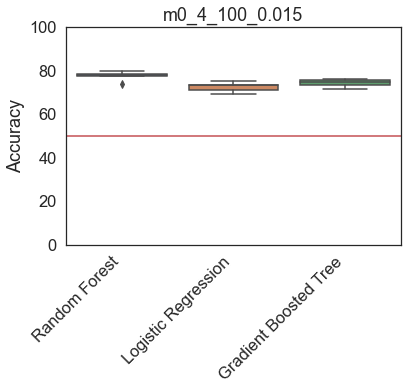

best accuracy 74


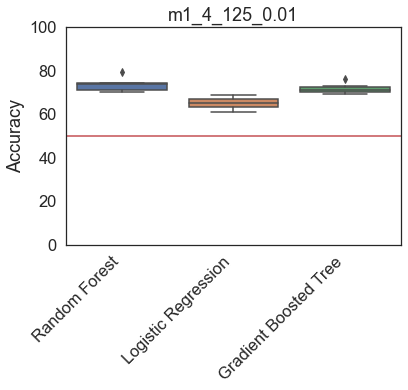

best accuracy 65


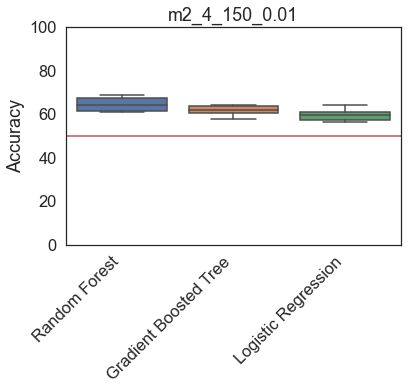

best accuracy 74


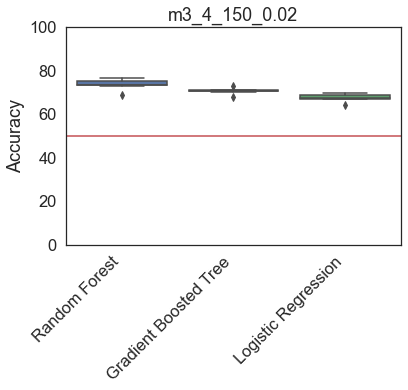

best accuracy 63


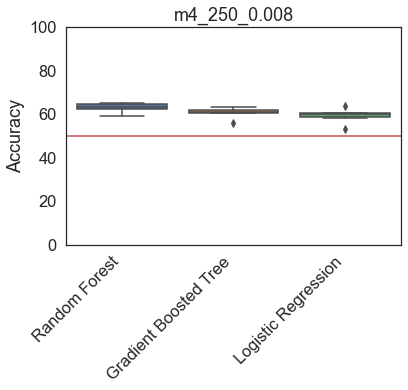

In [84]:
plot_ML_results(th_path, subnetwork_names)

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [97]:
lr = LogisticRegression(max_iter = 1000)
rf = RandomForestClassifier()
xgb = XGBClassifier()

In [106]:
os.getcwd()

'C:\\Users\\bbche\\Documents\\GitRepos\\assist\\notebooks\\models'

In [108]:
# save the models
import pickle

In [191]:
def run_ml(processed_embedding, emb_name, output_dir = None):
    lr_acc = []
    rf_acc = []
    xgb_acc = []
    for i in range(3):
        num_sample = processed_embedding.impact.value_counts().min()
        emb_subset = processed_embedding.groupby('impact').sample(num_sample).reset_index() # subset to have equal samples in the two classes
        X_train, X_test, y_train, y_test = train_test_split(emb_subset.iloc[:, :64], emb_subset['impact'], test_size = 0.2)
        lr.fit(X_train, y_train)
        rf.fit(X_train, y_train)
        xgb.fit(X_train, y_train)
        
        lr_acc.append(round(lr.score(X_test, y_test), 2))
        rf_acc.append(round(rf.score(X_test, y_test), 2))
        xgb_predict = xgb.predict(X_test)
        xgb_acc.append(round(accuracy_score(y_test, xgb_predict), 2))

        if output_dir:
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            pickle.dump(lr, open(output_dir + f'lr_{emb_name}{i}.pkl', 'wb'))
            pickle.dump(rf, open(output_dir + f'rf_{emb_name}{i}.pkl', 'wb'))
            pickle.dump(xgb, open(output_dir + f'xgb_{emb_name}{i}.pkl', 'wb'))
            print(emb_name, 'model saved')
    print('lr average:', np.mean(lr_acc))
    print('rf average:', np.mean(rf_acc))
    print('xgb_average:', np.mean(xgb_acc))

In [129]:
output_dirs = [f'../../data/{subnetwork_names[i]}/' for i in range(len(subnetwork_names))]

In [206]:
output = list(map(run_ml, processed_emb_dfs, ['']*5, output_dirs))

 model saved
 model saved
 model saved
lr average: 0.6766666666666667
rf average: 0.7266666666666666
xgb_average: 0.7133333333333333
 model saved
 model saved
 model saved
lr average: 0.66
rf average: 0.7266666666666666
xgb_average: 0.7133333333333333
 model saved
 model saved
 model saved
lr average: 0.61
rf average: 0.65
xgb_average: 0.65
 model saved
 model saved
 model saved
lr average: 0.68
rf average: 0.7333333333333334
xgb_average: 0.7000000000000001
 model saved
 model saved
 model saved
lr average: 0.61
rf average: 0.64
xgb_average: 0.61


In [149]:
def get_min_max_center(coef):
    '''A function to get min, max and avg used for heatmap in plot_feature_importances()'''
    min_value = coef.min()
    max_value = coef.max()
    center = np.mean([min_value, max_value])
    return min_value, max_value, center

In [148]:
def get_important_features(model):
    '''Get feature importances from models'''
    if type(model).__name__ == 'LogisticRegression':
        coef = model.coef_[0]
        coef = np.abs(coef) # convert coef to positive values only
        coef /= np.sum(coef) # convert coef to % importance
    else:
        coef = model.feature_importances_
    return coef

In [25]:
model_feature_importances = list(map(get_important_features, [lr, rf, xgb]))

In [303]:
def plot_feature_importances(model_path, print_num_dim = True, plot_heatmap = False, return_top_dim = False):
    '''A function to show feature importances in each model'''
    model_files = os.listdir(model_path)
    model_list = []
    for file in model_files:
        with open(model_path + '/' + file, 'rb') as model:
            model_list.append(pickle.load(model))
    models_feature_importances = list(map(get_important_features, model_list))
    if plot_heatmap == True:
        plt.figure(figsize = (7, 23))
        i = 0
        for coef in models_feature_importances:
            min_v, max_v, center = get_min_max_center(coef)
            plt.subplot(3, 3,i+1)
            sns.heatmap(coef.reshape(64, 1), center = center, vmin = min_v, vmax = max_v)
            plt.title(model_files[i])
            plt.subplots_adjust(wspace = 2)
            i += 1
    if print_num_dim == True and return_top_dim == True:
        top_dim_list = list(map(get_top_dim, models_feature_importances, model_files, [True]*len(models_feature_importances),
                                [0.2]*len(models_feature_importances), [True]*len(models_feature_importances)))
        return models_feature_importances, top_dim_list
    elif print_num_dim == False and return_top_dim == True:
        top_dim_list = list(map(get_top_dim, models_feature_importances, model_files, [False]*len(models_feature_importances),
                                [0.2]*len(models_feature_importances), [True]*len(models_feature_importances)))
        return models_feature_importances, top_dim_list
    else:
        top_dim_list = list(map(get_top_dim, models_feature_importances, model_files))
        return models_feature_importances

In [306]:
output_dirs

['../../data/m0_4_100_0.015/',
 '../../data/m1_4_125_0.01/',
 '../../data/m2_4_150_0.01/',
 '../../data/m3_4_150_0.02/',
 '../../data/m4_250_0.008/']

In [311]:
feat_importance_data = list(map(plot_feature_importances, output_dirs, [False]*len(output_dirs), [False]*len(output_dirs), [True]*len(output_dirs)))

In [325]:
feat_importance_list = [feat_importance_data[i][0] for i in range(len(feat_importance_data))]

In [328]:
top_dim_list = [feat_importance_data[i][1] for i in range(len(feat_importance_data))]

In [333]:
def get_top_dim(coef, model_name, print_num_dim = True, top_n_coef = 0.2, return_top_dim = False):
    '''
    Get the top features used for each ML and return as a list along with id and abs_log2FC for the get_pairwise_distances()
    top_n_coef: 0.2 means extract features up to 20% importance
    '''
    for i in range(64):
        if np.sum(coef[coef.argsort()[-i:]]) > top_n_coef:
            num_dim = i
            break 
    top_dim = [str(num) for num in coef.argsort()[-num_dim:]]
    if print_num_dim == True:
        print(f'Number of dim for {model_name}:', len(top_dim))
    
    if return_top_dim == True:
        top_dim += ['id', 'abs_log2FC']
#     emb_top_features = processed_emb_df[top_dim]
        return top_dim

In [331]:
from itertools import combinations
def jaccard_average(top_dim_list, title):
    new_top_dim_list = [dim_list[:-2] for dim_list in top_dim_list]
    jac_average = []
    for i in range(0, len(new_top_dim_list), 3): # each model was repeated 3 times 
        jac_list = []
        for dim_list1, dim_list2 in combinations(new_top_dim_list[i:i+3],2): # compare 2 out of 3 with all combinations
            jac_list.append(jaccard_similarity(a, b))
        jac_average.append(np.mean(jac_list))
    plt.bar(['lr', 'rf', 'xgb'], jac_average)
    plt.ylim(0, 1)
    plt.ylabel('jaccard similarity')
    plt.title(title)
    plt.show()
    plt.close()

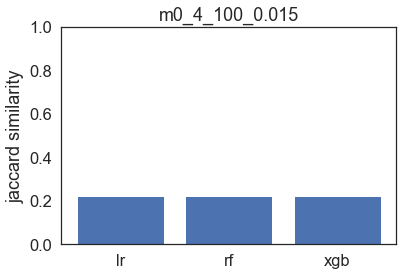

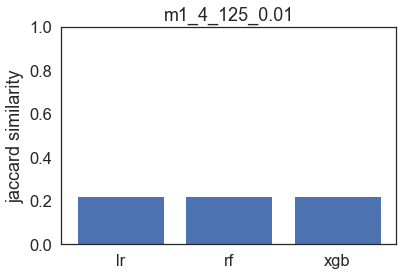

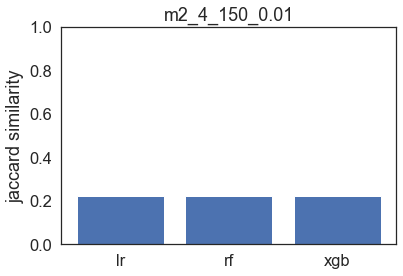

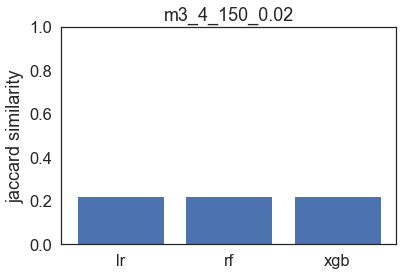

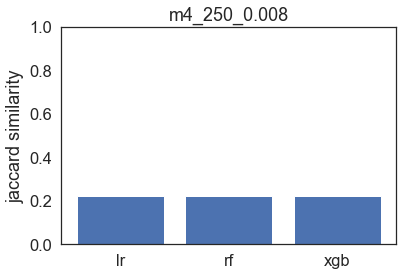

In [332]:
jaccard = list(map(jaccard_average, top_dim_list, subnetwork_names))

In [ ]:
## Do jaccard for the repeats of the same model

In [ ]:
## Compare jaccard if the "important dimension" was to be randomly selected vs determined by ML